# PACKAGES

In [1]:
# always needed
import os, random, csv, math
from math import gamma
from tabnanny import verbose # 偵測不良縮排
import pandas as pd
import numpy as np


# log and save
import json, logging, pickle, sys, shutil, copy
from argparse import ArgumentParser, Namespace
from pathlib import Path
from copy import copy
import joblib

# torch
import torch
import torch.nn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, models, transforms


# For plotting "learning curve"
# from torch.utils.tensorboard import SummaryWriter  #電腦好像找不到 tensorboard
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics


# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
if not os.path.isdir('./models'):
    os.mkdir('./models')
if not os.path.isdir('./models/model_weights'):
    os.mkdir('./models/model_weights')

config = {
    'seed': 507,
    'valid_ratio': 0.20,
    'n_epochs': 100,
    'batch_size': 16,
    'learning_rate': 1e-3,
    'early_stop': 10,
    'query_iteration': 20,
    'save_path_large': './models/model_weights/LargeModel.ckpt',
    'save_path_small': './models/model_weights/SmallModel.ckpt',
    'query_size': 20,
    'pool_size': 300
}

# 寫入自定義資料集
用unlabeled_mask來決定這筆 data被標注了沒，training的一部分跟所有的testing都是0<br>
沒標注過的資料unlabeled_mask=1 <br>
<i>專注在關心 index</i>
<br>創建valid set的預測結果紀錄，之後的iteration若是預測錯誤，就會變成該筆該輪的C

In [4]:
class IndexedDataset(Dataset):
    # data loading
    def __init__(self, df, TestOrValid=False, Valid=False):
        #df = pd.read_csv(file_name)
        self.x = torch.from_numpy(df.drop(columns=['Class']).to_numpy())
        self.x = self.x.to(torch.float32)

        '''真實的y, 但會顯示出的是label, 這邊的y幫助之後自動update unlabeled'''
        self.hidden_y = torch.from_numpy(df['Class'].to_numpy())
        self.n_samples = self.x.shape[0] #總共多少筆資料，不管有沒有label過
        #print(self.x.shape[0]) 多少個資料

        if TestOrValid: #如果是測試或驗證集，都會有答案的label
            self.labels = self.hidden_y
            self.unlabeled_mask = np.zeros(self.n_samples)
        else :
            self.labels = torch.from_numpy(np.array([-1]*self.n_samples)) #一開始將train label都設為-1
            self.unlabeled_mask = np.ones(self.n_samples)

        if Valid: #另外紀錄valid的一連串list
            self.prediction_record =  [[] for _ in range(self.n_samples)] #所有instance在valid set都有一串拿來紀錄的list

    # working for indexing
    def __getitem__(self, idx):
        return self.x[idx], self.labels[idx], idx
    def __len__(self):
        return self.n_samples

    # 這筆資料的當前資訊
    def display(self, idx):
        print(f'Data for this X:{self.x[idx]}')
        print(f'Label, mask for this X: label-{self.labels[idx]}, mask-{self.unlabeled_mask[idx]}')
        return
    def update_label_from_idx(self, idx):
        self.labels[idx] = self.hidden_y[idx]
        self.unlabeled_mask[idx] = 0 #代表他現在被標記了
        return
    def update_prediction_record(self, idx, prediction):
        self.prediction_record[idx].append(prediction)
        return

In [5]:
def plot_pred_record(pred_list):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    for i, lst in enumerate(pred_list):
        for j, val in enumerate(lst):
            color = 'green' if val == 1 else 'white'
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='black')
            ax.add_patch(rect)
    ax.set_xlim(0, len(pred_list[0]))
    ax.set_ylim(0, len(pred_list))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
def show_loss(train_loss, valid_loss):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(train_loss, color='blue', linewidth=2)
    axes[0].set_title('Training Loss', fontsize=16)
    axes[0].set_xlabel('iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot validation loss
    axes[1].plot(valid_loss, color='red', linewidth=2)
    axes[1].set_title('Validation Loss', fontsize=16)
    axes[1].set_xlabel('time', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## 重新規劃成三個index從0開始的資料集，互不干擾，方便丟進pytorch Loader

In [6]:
df = pd.read_csv('./data/preprocessed_beans_train.csv')
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42) # valid_ratio = 0.2
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df = pd.read_csv('./data/preprocessed_beans_test.csv')
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (8710, 17)
Validation set shape: (2178, 17)
Test set shape: (2723, 17)


In [7]:
#dataset_train = IndexedDataset(train_df)
dataset_valid = IndexedDataset(valid_df, TestOrValid=True, Valid=True)
dataset_test = IndexedDataset(test_df, TestOrValid=True)

batch_size = config['batch_size']
#train_loader = DataLoader(dataset_train ,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, drop_last=True)

In [8]:
for data, labels, idx in valid_loader:
    print(idx)
    break;

tensor([1490,    5,  277,  262, 2116, 1127, 1821,  200,  530, 1101, 1538,  657,
         957,  921,  827, 1281])


# Models

## Teacher Model Structure

In [9]:
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()

        self.linear1 = nn.Linear(16, 216)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(216, 128)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(128, 42)
        self.act3 = nn.ReLU()
        self.linear4 = nn.Linear(42, 7)

        self.dropout = nn.Dropout(0.1)
        self.bn1 = nn.BatchNorm1d(216)
        self.bn2 = nn.BatchNorm1d(84)

    def forward(self, x):
        x = self.act1(self.linear1(x))
        #x = self.bn1(x)
        x = self.dropout(x)
        x = self.act2(self.linear2(x))
        #x = self.bn2(x)
        x = self.dropout(x)
        x = self.act3(self.linear3(x))
        x = self.linear4(x)
        return x
teacher_model = ComplexModel().to(device)
print(teacher_model)

ComplexModel(
  (linear1): Linear(in_features=16, out_features=216, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=216, out_features=128, bias=True)
  (act2): ReLU()
  (linear3): Linear(in_features=128, out_features=42, bias=True)
  (act3): ReLU()
  (linear4): Linear(in_features=42, out_features=7, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Student Model Structure

In [10]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear1 = torch.nn.Linear(16, 42)
        self.linear2 = torch.nn.Linear(42, 7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
student_model_ori = SimpleModel().to(device) #一個baseline model
student_model_kd = SimpleModel().to(device)  #一個全新的用於kd的student model

## 資料取樣方式
- random_query: 隨機從未標注資料挑出n筆資料
- least_confidence: logit在softmax後取出，找出對於最大的那類預測最低的idx
- margin: 預測第一大的跟預測第二大的相減最小

In [11]:
'''
Each query strategy below returns a list of len=query_size with indices of
samples that are to be queried.
- query_size (int): number of samples to be queried for labels (default=20)

'''
def init_query(query_size=20):
    seed = 44 #隨意選都可
    return list(range(seed, seed + query_size))
    #return list(range(query_size)) #直接給train_df的前面20筆，因為在random_split時已經reset_index過了
def random_query(data_loader, query_size=20):
    sample_idx = []
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        _, _, idx = batch
        sample_idx.extend(idx.tolist())
        if len(sample_idx) >= query_size:
            break
    return sample_idx[0:query_size]

def least_confidence_query(model, device, data_loader, query_size=20):
    confidences = []
    indices = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)

            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0] #取得最大概率的類別的值
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())

    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

def margin_query(model, device, data_loader, query_size=20):
    margins = []
    indices = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)

            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]

## 流程：
Training data中先隨機給一定數量已標注的作為起始 訓練model_0, 再n筆一次一次的給他加入新的labeled data, <br>
valid dataset用來選擇教師，期待他跟training set有著類似的資料分布<br>
用選擇出的teacher model來和ground truth 一起訓練一個這輪的新model_i

## 使用者標注
選擇被標注時要不要用pooling來阻擋outliers?<br>

In [12]:
def query_the_oracle(model, device, dataset, query_size=20, query_strategy='random',
                      pool_size=0, batch_size=32, num_workers=0):

    unlabeled_idx = np.nonzero(dataset.unlabeled_mask)[0]
    # Select a pool of samples to query from
    if pool_size > 0:
        pool_idx = random.sample(range(1, len(unlabeled_idx)), pool_size)
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx[pool_idx]))
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,
                                              sampler=SubsetRandomSampler(unlabeled_idx))
    if query_strategy == 'init':
        sample_idx = init_query(query_size)
    elif query_strategy == 'margin':
        sample_idx = margin_query(model, device, pool_loader, query_size)
    elif query_strategy == 'least_confidence':
        sample_idx = least_confidence_query(model, device, pool_loader, query_size)
    else:
        sample_idx = random_query(pool_loader, query_size)
    # 更新哪些unlabeled 被標注
    for sample in sample_idx:
        dataset.update_label_from_idx(sample)

# 單次訓練過程，KD loss Function

In [13]:
# 自定義T, alpha KD_loss_function
def loss_kd(student_logits, labels, teacher_logits, temparature=5, alpha=0.7):
    soft_loss = nn.KLDivLoss(reduction="batchmean") #KLdistance算student軟標籤和teacher軟標籤
    distillation_loss = soft_loss(
                  F.log_softmax(student_logits/temparature, dim=1),
                  F.softmax(teacher_logits/temparature,dim=1)
                  )* (temparature * temparature)
    student_loss = F.cross_entropy(student_logits, labels)
    #print(f'student_loss: {student_loss}, distill_loss: {distillation_loss}')
    total_loss = (1-alpha)*student_loss + alpha*distillation_loss
    return total_loss

def train(model, device, train_loader, teacher_model, kd=False):  #直接對傳入的model訓練
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(),lr=3e-3,weight_decay=1e-4)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0.0001)
    epoch_loss = 0
    train_correct = 0
    m_train = 0 #這次有幾筆labeled資料用來訓練
    for batch in train_loader:
        datas, labels, _ = batch
        m_train += datas.size(0)
        datas, labels = datas.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(datas)
        _, train_pred = torch.max(outputs, 1) #不關心最大的數值，只要index
        train_correct += (train_pred.detach() == labels.detach()).sum().item()
        if kd:
            teacher_outputs = teacher_model(datas) # 教師output
            teacher_outputs = teacher_outputs.detach()  # 切斷教師反向傳播
            loss = loss_kd(outputs, labels, teacher_outputs)
        else:
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / m_train, m_train, train_correct / m_train

def test(model, device, data_loader): #可能是test也可能是valid，只看準確度
    test_correct = 0
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            datas, labels, _ = batch
            datas, labels = datas.to(device), labels.to(device)
            outputs = model(datas)
            _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
            test_correct += (test_pred.cpu() == labels.cpu()).sum().item()
    return test_correct/(len(dataset_test))

## 更新valid set的有無被正確預測矩陣
每次訓練出一個模型代表該iteration，要
- 得到test acc (用test func達成)
- 跑過每一個valid set的data, 紀錄他在這輪有沒有被正確預測
<br>理論上valid set的每一個instance, 會有一個list記載他每回合有沒有被預測對

In [14]:
def modify_valid_record(model, device, data_loader, dataset_valid):
    model.eval()
    #print('prediction_record: ',dataset_valid.prediction_record)
    with torch.no_grad():
        for batch in data_loader:
            datas, labels, idx = batch
            datas, labels = datas.to(device), labels.to(device)
            outputs = model(datas)
            _, test_pred = torch.max(outputs, 1) # test_pred就是類別預測值

            for i in range(len(idx)):
                if test_pred[i] == labels[i]:
                  #print(f"Sample {idx[i]} prediction is correct")
                  dataset_valid.update_prediction_record(idx[i], 1) #idx, prediction
                else:
                  #print(f"Sample {idx[i]} prediction is incorrect")
                  dataset_valid.update_prediction_record(idx[i], 0) #idx, prediction

## 教師的選擇

In [15]:
def choose_teacher(current_model, dataset_valid, valid_loader, previous_model_num): #previous_model_num=2代表有model_0, model_1 可供選擇
    if previous_model_num == 1 or previous_model_num == 2: return 0 #前面兩輪的選擇必定直接為第0個model

    '''
    如果當前iteration傳入的model(current_model)預測這筆資料正確label的softmax, 低於
    過往model的softmax probability -> 採用這筆C
    原始論文說要過softmax,但會使得概率差距過大,所以我直接用歸一化
    current_model為上一輪訓練出的model, 我們要知道他預測錯哪些data
    '''
    #用當前current_model 算出每個data的C
    sum_list = [sum(sub_list) for sub_list in dataset_valid.prediction_record] #每個data的原始C總和,之後只有這個model預測錯的會被留著
    predict_proba_list = np.zeros(dataset_valid.n_samples) #初始化一個list儲存current_model對每個data的softmax預測值
    current_model.eval()
    for batch in valid_loader:
        datas, labels, idx = batch
        datas, labels = datas.to(device), labels.to(device)
        outputs = current_model(datas)
        outputs = F.softmax(outputs, dim=1) #過softmax
        best_proba, test_pred = torch.max(outputs, 1) # best_proba為對該類別的預測機率，test_pred就是類別預測
        for i in range(len(idx)):
            predict_proba_list[idx[i]] = best_proba[i].detach().cpu().numpy() #probability加入list，方便之後比較
            if test_pred[i] == labels[i]: #這筆資料預測對了
                sum_list[idx[i]] = 0 #就不用考慮這筆的C

    # 平滑化操作，用上面得到需要採用的C's 並平滑化作為底下選擇的基準
    total_sum = sum(sum_list)
    consistency_list = [x / total_sum for x in sum_list] #用來選這次teacher的C list

    ''' consistency_list長的會像 [0.1, 0, 0, 0, 0.5, 0.05, 0, 0, 0.25, 0.1, 0] 理論上0會很多
        如果previous model預測在softmax後，在某一筆上面表現比current_model在那筆資料好，
        且該筆資料的consistency_list 不為0, 代表是好事，把它 (probability*C) 加進current score 裏'''
    best_model = 0
    best_score = 0
    for t in range(previous_model_num - 1): #跑過所有過往的model除了上一輪的
        current_score = 0
        PATH = f'./models/model_{t}.pt'
        previous_model = ComplexModel().to(device)
        previous_model.load_state_dict(torch.load(PATH))
        previous_model.eval()
        for batch in valid_loader: #valid set的資料用來選teacher
            datas, labels, idx = batch
            datas, labels = datas.to(device), labels.to(device)
            outputs = previous_model(datas)
            outputs = F.softmax(outputs, dim=1)
            best_proba, _ = torch.max(outputs, 1) # best_proba為對該類別的預測機率
            for i in range(len(idx)):
                if best_proba[i] > predict_proba_list[idx[i]]: #若是這個過往模型對於這筆資料的預測值大於current_model，score += 這個模型Output的機率＊這筆資料的Ｃ
                    current_score += best_proba[i].detach().cpu().numpy() * consistency_list[idx[i]] #這樣下來，若是預測C=0的就會變成+0 沒有用
        #在每一輪過往的model，看他的score有沒有比當前最好的更高，若是有，更新他為best_model, 更新best_score
        if current_score >= best_score:
            best_model = t
            best_score = current_score

        #print(f'current_score: {current_score}')
        #print(f'best_model: {best_model}')

    return best_model

## 保存地址：
如何保存model? https://pytorch.org/tutorials/beginner/saving_loading_models.html<br>
分兩種，可以繼續訓練的或只能拿來eval的，這裡不需要繼續訓練於是選只能eval的<br>
torch.save(model.state_dict(), PATH)<br>
model = TheModelClass(*args, **kwargs)<br>
model.load_state_dict(torch.load(PATH))<br>
model.eval()<br>
通常檔案結尾為pt 如save('model_i.pt')



In [16]:
if not os.path.isdir('./models'):
    os.mkdir('./models') # Create directory of saving models.

# 真正開始訓練
對於三種取樣方法各自先初始化該dataset_train與給予一部分作為初始值後開始<br>
只要改過程中的query_strategy就可，不用改初始化用到的<br>
分別把過程中存下的test_acc存在各自的list<br>
(random_test_acc, confidence_test_acc, margin_test_acc)

## 比較三種策略在此
model 從0起始
迴圈從1到T

In [17]:
def use_labeled_to_train(model, device, dataset_train, valid_loader, teacher_model, kd=False):
    # Train the model on the data that has been labeled so far:
    labeled_idx = np.where(dataset_train.unlabeled_mask == 0)[0]
    # 只包含有標記過training data 的dataloader
    labeled_train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=0, sampler=SubsetRandomSampler(labeled_idx)) # set num_workers=0 to avoid parallel works

    previous_best_acc = 0
    fail_cnt = 0
    while fail_cnt < 2 : #反覆對這些資料訓練直到valid準確率不再上升n輪
        train_loss, train_data_num, train_acc = train(model, device, labeled_train_loader, teacher_model=teacher_model, kd=kd) #固定都會傳teacher,但kd=True才會用到
        current_valid_acc = test(model, device, valid_loader)
        if current_valid_acc > previous_best_acc:
            fail_cnt = 0 #重新計算，因為成功找到更好的model
            previous_best_acc = current_valid_acc
        else:
            fail_cnt += 1
        #print(f'train_acc: {train_acc}')
    print(f"train acc: {train_acc}, train loss:{train_loss}, valid loss:{previous_best_acc}, how many train data:{train_data_num}")

In [18]:
query_size_define = config['query_size'] #20
pool_size_define = config['pool_size'] #0?2000?
def compare_strategy_get_acc(strategy='random'):
    # 初始化一開始的訓練集,測試集，隨機放一些資料進去，random時query_the_oracle的model放誰不重要
    test_acc_list = []
    teacher_list = [0]
    dataset_train = IndexedDataset(train_df)
    dataset_valid = IndexedDataset(valid_df, TestOrValid=True, Valid=True)
    valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, drop_last=True)


    # 第0個model, 初始的model用20個統一初始資料來訓練，理論上三種取樣方式的起始test_acc會差不多
    model = ComplexModel().to(device) #先訓練一個seed model 用初始隨機資料
    query_the_oracle(model, device, dataset_train, query_size=query_size_define, query_strategy='init', pool_size=pool_size_define) #取得的參數統一為init
    use_labeled_to_train(model, device, dataset_train, valid_loader, teacher_model=model, kd=False) #訓練, teacher隨便放

    # Test the model on test set
    test_acc = test(model, device, test_loader)
    print(f"Iteration: 0, test acc: {test_acc}\n")
    test_acc_list.append(test_acc)
    PATH = f'./models/model_0.pt'
    torch.save(model.state_dict(), PATH) #儲存model

    """這邊改iteration數"""
    num_iteration = config['query_iteration'] #50
    for iteration in range(1, num_iteration):
        # 每個iteration的開始加入一些labeled data 到training，用上個迴圈還沒被重置的model
        query_the_oracle(model, device, dataset_train, query_size=query_size_define, query_strategy=strategy, pool_size=pool_size_define) #用上一輪的model去拿到新的資料
        modify_valid_record(model, device, valid_loader, dataset_valid) #用上一輪的model去更新valid上的預測至目前

        '''看看當今model會錯在哪裡用來更新C(correct consistency),也代表著這個被傳入的model不會是teacher(除了前面兩輪)
            同時找到過往的teacher -> '''
        number_teacher = choose_teacher(model, dataset_valid, valid_loader, previous_model_num = iteration) #iteration從1~50 拿到teacher是哪個過往model
        teacher_list.append(number_teacher)
        model = ComplexModel().to(device) #重新訓練一個model在每個iteration, 跟一個代表過往模型的teacher_model
        print(f'This iteration {iteration}, the teacher is {number_teacher}')
        teacher_model = ComplexModel().to(device)
        teacher_model.load_state_dict(torch.load(f'./models/model_{number_teacher}.pt'))
        teacher_model.eval()
        '''此處採用Knowledge Distillation來訓練'''
        use_labeled_to_train(model, device, dataset_train, valid_loader, teacher_model=teacher_model, kd=True) #kd=true 給teacher


        # Test the model on test set, save the model for this iteration
        test_acc = test(model, device, test_loader)
        print(f"Iteration: {iteration}, test acc: {test_acc}\n\n")
        test_acc_list.append(test_acc)
        PATH = f'./models/model_{iteration}.pt'
        torch.save(model.state_dict(), PATH) #儲存model

    pred_record = dataset_valid.prediction_record
    selected_lists = random.sample(pred_record, 50) #隨機選50個出來show
    plot_pred_record(selected_lists) #畫出預測紀錄
    return test_acc_list, teacher_list, dataset_train #回傳每個iteration在此策略上的測試準確度, 各個iteration的教師, 最後使用了哪些train_Data

### Confidence採樣測試
估計容易受到outliers影響，可能要加上pooling

train acc: 0.6, train loss:0.1143062174320221, valid loss:0.3878075651854572, how many train data:20
Iteration: 0, test acc: 0.4495042232831436

This iteration 1, the teacher is 0
train acc: 0.925, train loss:0.02555226758122444, valid loss:0.5460888725670217, how many train data:40
Iteration: 1, test acc: 0.6731546088872568


This iteration 2, the teacher is 0
train acc: 0.9, train loss:0.024555659294128417, valid loss:0.633492471538744, how many train data:60
Iteration: 2, test acc: 0.803892765332354


This iteration 3, the teacher is 0
train acc: 0.9375, train loss:0.022454892098903657, valid loss:0.6423062798384135, how many train data:80
Iteration: 3, test acc: 0.7590892398090342


This iteration 4, the teacher is 0
train acc: 0.86, train loss:0.027204218804836273, valid loss:0.6301872934263679, how many train data:100
Iteration: 4, test acc: 0.8053617333822989


This iteration 5, the teacher is 0
train acc: 0.7666666666666667, train loss:0.027736412733793257, valid loss:0.6408373

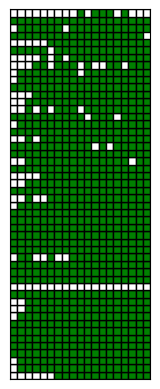

[0.4495042232831436, 0.6731546088872568, 0.803892765332354, 0.7590892398090342, 0.8053617333822989, 0.7961806830701432, 0.8508997429305912, 0.8417186926184356, 0.8538376790304811, 0.8428204186558942, 0.8677928755049578, 0.8747704737421961, 0.87146529562982, 0.8707308116048476, 0.8688946015424165, 0.8751377157546824, 0.8799118619170033, 0.8758721997796548, 0.8799118619170033, 0.8604480352552332]
[0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 8, 6, 10, 10, 10, 13, 14, 14, 14, 13]


In [19]:
confidence_test_acc, confidence_teacher_list, confidence_train_data_selected = compare_strategy_get_acc('least_confidence')
print(confidence_test_acc)
print(confidence_teacher_list)

### Margin 採樣測試

train acc: 0.6, train loss:0.15507858991622925, valid loss:0.442159383033419, how many train data:20
Iteration: 0, test acc: 0.5479250826294528

This iteration 1, the teacher is 0
train acc: 0.875, train loss:0.025925909727811815, valid loss:0.6492838780756518, how many train data:40
Iteration: 1, test acc: 0.7998531031950055


This iteration 2, the teacher is 0
train acc: 0.8333333333333334, train loss:0.02597780923048655, valid loss:0.6731546088872568, how many train data:60
Iteration: 2, test acc: 0.8292324641939037


This iteration 3, the teacher is 1
train acc: 0.825, train loss:0.01793965958058834, valid loss:0.6764597869996327, how many train data:80
Iteration: 3, test acc: 0.8277634961439588


This iteration 4, the teacher is 1
train acc: 0.79, train loss:0.021979166269302366, valid loss:0.6841718692618436, how many train data:100
Iteration: 4, test acc: 0.8538376790304811


This iteration 5, the teacher is 3
train acc: 0.5666666666666667, train loss:0.027838973701000212, valid

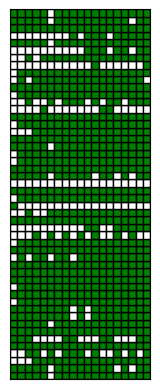

[0.5479250826294528, 0.7998531031950055, 0.8292324641939037, 0.8277634961439588, 0.8538376790304811, 0.6588321704002938, 0.8586118251928021, 0.8710980536173338, 0.882482556004407, 0.8699963275798751, 0.9015791406536908, 0.9159015791406537, 0.9118619170033052, 0.884318766066838, 0.9063532868160118, 0.9122291590157914, 0.8802791039294895, 0.9166360631656262, 0.9136981270657363, 0.9133308850532501]
[0, 0, 0, 1, 1, 3, 4, 3, 6, 7, 8, 9, 10, 9, 9, 10, 14, 10, 16, 16]


In [20]:
margin_test_acc, margin_teacher_list, margin_train_data_selected = compare_strategy_get_acc('margin')
print(margin_test_acc)
print(margin_teacher_list)

### Random 版本

train acc: 0.55, train loss:0.12439780235290528, valid loss:0.40910760190965845, how many train data:20
Iteration: 0, test acc: 0.4674990818949688

This iteration 1, the teacher is 0
train acc: 0.8, train loss:0.023634278774261476, valid loss:0.5828130738156445, how many train data:40
Iteration: 1, test acc: 0.7238340066103562


This iteration 2, the teacher is 0
train acc: 0.85, train loss:0.019184862822294237, valid loss:0.5589423430040397, how many train data:60
Iteration: 2, test acc: 0.6786632390745502


This iteration 3, the teacher is 0
train acc: 0.975, train loss:0.01687573455274105, valid loss:0.6654425266250459, how many train data:80
Iteration: 3, test acc: 0.8402497245684907


This iteration 4, the teacher is 1
train acc: 0.96, train loss:0.01572330191731453, valid loss:0.6705839147998531, how many train data:100
Iteration: 4, test acc: 0.8486962908556739


This iteration 5, the teacher is 1
train acc: 0.9333333333333333, train loss:0.015858746444185574, valid loss:0.68710

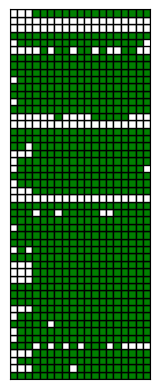

[0.4674990818949688, 0.7238340066103562, 0.6786632390745502, 0.8402497245684907, 0.8486962908556739, 0.8486962908556739, 0.8931325743665075, 0.8674256334924716, 0.8641204553800955, 0.8527359529930224, 0.842453176643408, 0.8920308483290489, 0.9085567388909291, 0.9023136246786633, 0.8993756885787734, 0.9001101726037458, 0.8780756518545721, 0.8828497980168931, 0.8699963275798751, 0.8703635695923614]
[0, 0, 0, 0, 1, 1, 4, 1, 1, 4, 2, 6, 6, 11, 6, 12, 9, 10, 10, 10]


In [21]:
random_test_acc, random_teacher_list, random_train_data_selected = compare_strategy_get_acc('random')
print(random_test_acc)
print(random_teacher_list)

# 參數 發現&紀錄
- 每次在訓練時，都是從頭訓練一個模型，一開始我怕在每個iteration時對這筆資料訓練太少次。所以我設定要連續讓valid set準確率不上升8輪(fail_count)，才是完整的訓練了這次資料。但後來在抓錯時才發現這樣會直接一個大overfit,因為剛開始訓練資料不多 而且測試集上效果反而沒有後來好（後來設定不再上升1~2輪都不錯)，並且達成不再上升八次這個門檻很困難，反而會浪費很多運算資源&訓練時間，而且設定輪次少後可以多幾輪訓練，放更多訓練資料進去看曲線

- softmax設定問題還是正常的平均在label <b>Consistency</b> List
- 找不到作者的程式碼(論文說有appendix顯示出一些他們試過的超參數跟其他的東西), 試過很多Temperature&alpha 在過往模型訓練知識蒸餾的超參數，但不好畫出比較圖太慢
- 方法如random, 或是有時候fail_count調太高,或是知識蒸餾的參數調整，會讓模型過度偏袒一開始的模型0, 導致都取它作為teacher model, 有考慮要不要在每個iteration把先前的Consistency list都呈上一些衰減率

## 繪圖比較三者的差異

/Users/huangrongzun/Desktop/colab-to-local/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/huangrongzun/Desktop/colab-to-local/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/huangrongzun/Desktop/colab-to-local/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/huangrongzun/Desktop/colab-to-local/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

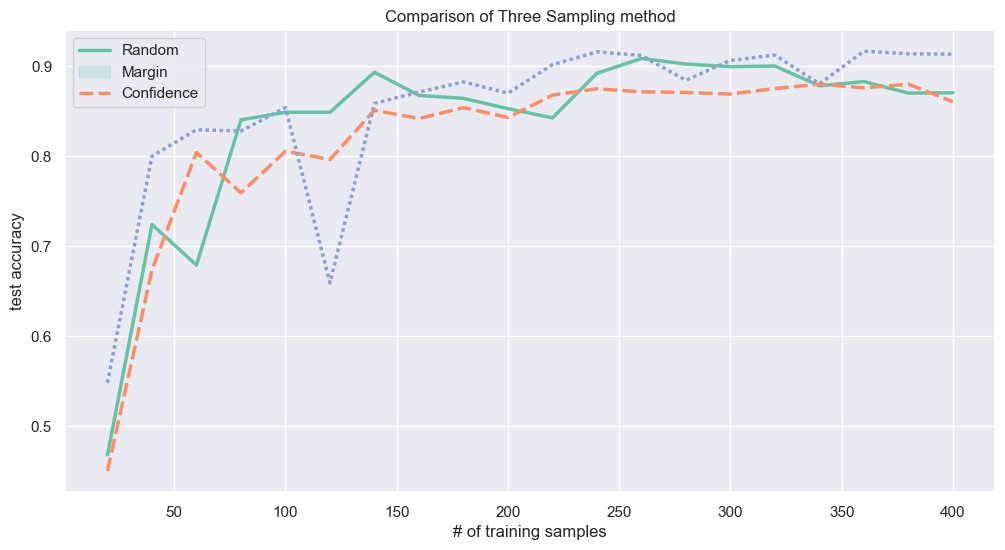

In [22]:
import seaborn as sns
data = pd.DataFrame({'x': range(config['query_size'], config['query_size']*(config['query_iteration']+1), config['query_size']),
                     'Random': random_test_acc, 'Confidence': confidence_test_acc, 'Margin': margin_test_acc})
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=data.set_index('x'), palette="Set2", linewidth=2.5)
plt.legend(labels=["Random", "Margin", "Confidence"])
plt.xlabel("# of training samples")
plt.ylabel("test accuracy")
plt.title("Comparison of Three Sampling method")
plt.show()

## 呈現每一輪Teacher是如何被選擇

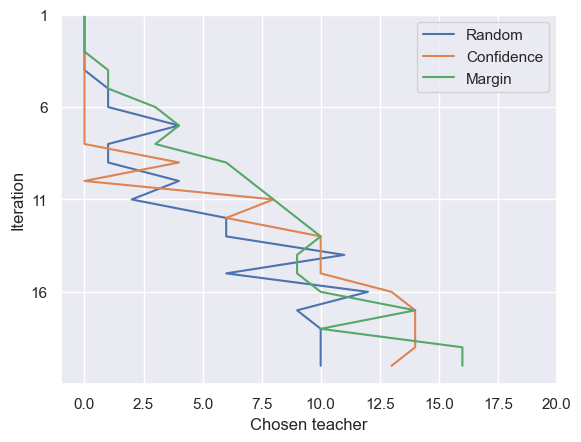

In [23]:
#改畫三條線
y_coordinates = range(config['query_iteration'], 0, -1)
plt.plot(random_teacher_list, y_coordinates, label='Random')
plt.plot(confidence_teacher_list, y_coordinates, label='Confidence')
plt.plot(margin_teacher_list, y_coordinates, label='Margin')
plt.xlim(-1, config['query_iteration'])
plt.ylim(0, config['query_iteration'])
plt.xlabel('Chosen teacher')
plt.ylabel('Iteration')
plt.yticks(range(config['query_iteration'], 0, -5), range(1, config['query_iteration']+1, 5))
plt.legend()
plt.show()

## 畫出方格圖（採用三者之平均）

In [24]:
list_all = [random_teacher_list, confidence_teacher_list, margin_teacher_list]
n = len(list_all[0])
matrix = np.zeros((n, n))  # 创建一个n x n的全零矩阵
for lst in list_all:
    for i in range(n):
        matrix[i][lst[i]] += 1
arr = np.array(matrix)
sums = np.sum(arr, axis=1)
normalized_arr = arr / sums[:, np.newaxis]

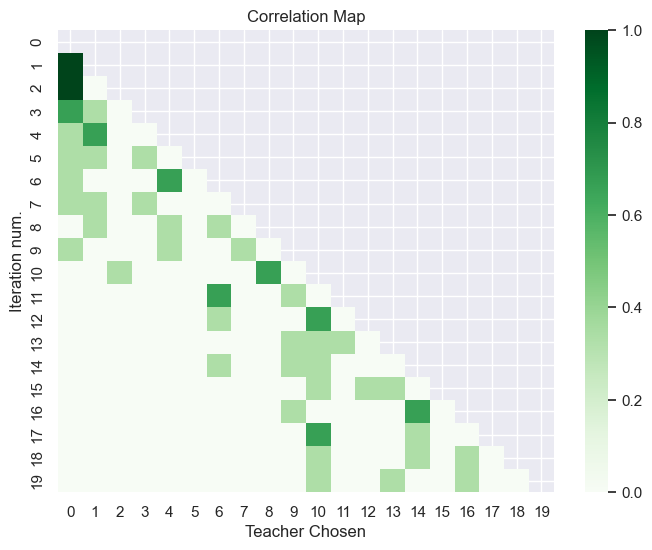

In [25]:
mask = np.triu(np.ones_like(normalized_arr))
#cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(normalized_arr, mask=mask, cmap='Greens', annot=False, fmt=".2f", square=False, cbar=True) #Greens_r 像原版
ax.set_xlabel('Teacher Chosen')
ax.set_ylabel('Iteration num.')
ax.set_title('Correlation Map')
plt.show()

# 使用三種採樣方式中表現最好的train data，重新訓練一個完整的Teacher Model
### 目前看是Margin效果最好，使用了1/8的總Training data
於是接下來完整的訓練採用margin挑出來的那些Training data

In [26]:
# labeled train dataset = margin_train_data_selected

labeled_idx = np.where(margin_train_data_selected.unlabeled_mask == 0)[0]
# 只包含有標記過training data 的dataloader
labeled_train_loader = DataLoader(margin_train_data_selected, batch_size=batch_size, num_workers=0, sampler=SubsetRandomSampler(labeled_idx))

In [27]:
len(labeled_idx)

400

## 直接套用之前的KD完整訓練流程

In [28]:
#train完整teacher
def final_train_teacher(train_loader, valid_loader, model, model_name, epochs_num):

    criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
    optimizer = optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
    loss_train = []
    loss_valid = []
    best_loss, early_stop_count = math.inf, 0

    for epoch in range(epochs_num):
        #print(f'loss_train:{loss_train}')
        model.train() # Set model to train mode
        cur_train_loss = []
        cur_valid_loss = []
        train_pbar = tqdm(train_loader, position=0, leave=True)
        for datas, labels, _ in train_pbar: #each batch
            datas, labels = datas.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(datas)
            loss = criterion(outputs, labels)
            loss.backward() #反向傳播
            optimizer.step()
            cur_train_loss.append(loss.detach().cpu().numpy())
        #print(cur_train_loss)
        mean_loss_train = sum(cur_train_loss)/len(cur_train_loss)
        #-----------------------validation----------------------#
        model.eval()
        with torch.no_grad(): #代表這裡面不會有backpropagation梯度，不會有調整優化
            for datas, labels, _ in valid_loader:
                datas, labels = datas.to(device), labels.to(device)
                outputs = model(datas)
                loss = criterion(outputs, labels)
                cur_valid_loss.append(loss.detach().cpu().numpy())

            mean_loss_valid = sum(cur_valid_loss)/len(cur_valid_loss)
            print(f"Epoch [{epoch+1}/{epochs_num}]: Train loss: {mean_loss_train:.4f}, Valid loss: {mean_loss_valid:.4f}")
            loss_train.append(mean_loss_train)
            loss_valid.append(mean_loss_valid)
            if mean_loss_valid < best_loss:
                best_loss = mean_loss_valid
                torch.save(model.state_dict(), config['save_path_large'])
                print(f'Saving model with loss {best_loss:.4f}')
                early_stop_count = 0
            else:
                early_stop_count += 1
            
#             # 先不管準確度，直接存，只為了跑完整份檔案
#             torch.save(model.state_dict(), config['save_path_large'])
#             print(f'Saving model with loss {best_loss:.4f}')
            
            
            if early_stop_count >= config['early_stop']:
                print('\n Model is not improving, Stop training session.')
                return

    show_loss(loss_train, loss_valid)

## KD

In [29]:
# 自定義T, alpha 此處調整alpha較高因為是要教學生 直接從這邊改參數
def final_loss_kd(student_logits, labels, teacher_logits, temparature=3, alpha=0.95):
    soft_loss = nn.KLDivLoss(reduction="batchmean") #KLdistance算student軟標籤和teacher軟標籤
    distillation_loss = soft_loss(
                  F.log_softmax(student_logits/temparature, dim=1),
                  F.softmax(teacher_logits/temparature,dim=1)
                  )* (temparature * temparature)
    student_loss = F.cross_entropy(student_logits, labels)
    total_loss = (1-alpha)*student_loss + alpha*distillation_loss
    return total_loss
#train完整student
def final_train_student(train_loader, valid_loader, student_model, teacher_model, model_name, epochs_num):

    teacher_model.eval()
    criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
    optimizer = optim.AdamW(student_model.parameters(),lr=1e-3,weight_decay=1e-4)
    loss_train = []
    loss_valid = []
    best_loss, early_stop_count = math.inf, 0

    for epoch in range(epochs_num):
        student_model.train() # Set model to train mode
        cur_train_loss = []
        cur_valid_loss = []
        train_pbar = tqdm(train_loader, position=0, leave=True)
        for datas, labels, _ in train_pbar: #each batch
            datas, labels = datas.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student_model(datas)
            teacher_outputs = teacher_model(datas) # 教師output
            teacher_outputs = teacher_outputs.detach()  # 切斷教師反向傳播

            loss = final_loss_kd(student_outputs, labels, teacher_outputs)
            loss.backward() #反向傳播
            optimizer.step()
            cur_train_loss.append(loss.detach().cpu().numpy())

        mean_loss_train = sum(cur_train_loss)/len(cur_train_loss)
        #-----------------------validation----------------------#
        student_model.eval()
        with torch.no_grad(): #代表這裡面不會有backpropagation梯度，不會有調整優化
            for datas, labels, _ in valid_loader:
                datas, labels = datas.to(device), labels.to(device)
                student_outputs = student_model(datas)
                teacher_outputs = teacher_model(datas) # 教師output
                teacher_outputs = teacher_outputs.detach()  # 切斷教師反向傳播
                loss = final_loss_kd(student_outputs, labels, teacher_outputs)
                cur_valid_loss.append(loss.detach().cpu().numpy())

            mean_loss_valid = sum(cur_valid_loss)/len(cur_valid_loss)
            print(f"Epoch [{epoch+1}/{epochs_num}]: Train loss: {mean_loss_train:.4f}, Valid loss: {mean_loss_valid:.4f}")
            loss_train.append(mean_loss_train)
            loss_valid.append(mean_loss_valid)
            if mean_loss_valid < best_loss:
                best_loss = mean_loss_valid
                torch.save(student_model.state_dict(), config['save_path_small'])
                print(f'Saving model with loss {best_loss:.4f}')
                early_stop_count = 0
            else:
                early_stop_count += 1
            
            
#             # 先不管準確度，直接存，只為了跑完整份檔案
#             torch.save(model.state_dict(), config['save_path_large'])
#             print(f'Saving model with loss {best_loss:.4f}')
            
            
            if early_stop_count >= config['early_stop']:
                print('\n Model is not improving, Stop training session.')
                return

    show_loss(loss_train, loss_valid)

## Train

In [30]:
dataset_valid = IndexedDataset(valid_df, TestOrValid=True, Valid=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, drop_last=True)

In [32]:
num_epoch = config['n_epochs']
teacher_model = ComplexModel().to(device)
final_train_teacher(labeled_train_loader, valid_loader, teacher_model, "Teacher", epochs_num = num_epoch)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/100]: Train loss: 1.8078, Valid loss: 1.5937
Saving model with loss 1.5937


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/100]: Train loss: 1.3872, Valid loss: 1.0486
Saving model with loss 1.0486


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/100]: Train loss: 1.1827, Valid loss: 0.8977
Saving model with loss 0.8977


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/100]: Train loss: 1.1013, Valid loss: 0.8378
Saving model with loss 0.8378


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/100]: Train loss: 1.0762, Valid loss: 0.7908
Saving model with loss 0.7908


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/100]: Train loss: 1.0321, Valid loss: 0.7460
Saving model with loss 0.7460


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/100]: Train loss: 0.9966, Valid loss: 0.7336
Saving model with loss 0.7336


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/100]: Train loss: 0.9475, Valid loss: 0.7346


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/100]: Train loss: 0.9376, Valid loss: 0.6858
Saving model with loss 0.6858


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/100]: Train loss: 0.9404, Valid loss: 0.6798
Saving model with loss 0.6798


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/100]: Train loss: 0.9193, Valid loss: 0.6714
Saving model with loss 0.6714


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/100]: Train loss: 0.8977, Valid loss: 0.6802


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/100]: Train loss: 0.8943, Valid loss: 0.6831


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/100]: Train loss: 0.9152, Valid loss: 0.6758


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/100]: Train loss: 0.9025, Valid loss: 0.6455
Saving model with loss 0.6455


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/100]: Train loss: 0.8676, Valid loss: 0.6431
Saving model with loss 0.6431


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/100]: Train loss: 0.8465, Valid loss: 0.6408
Saving model with loss 0.6408


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/100]: Train loss: 0.8475, Valid loss: 0.6435


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/100]: Train loss: 0.8215, Valid loss: 0.6329
Saving model with loss 0.6329


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/100]: Train loss: 0.8308, Valid loss: 0.6357


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/100]: Train loss: 0.8243, Valid loss: 0.6417


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/100]: Train loss: 0.8194, Valid loss: 0.6538


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/100]: Train loss: 0.8403, Valid loss: 0.6281
Saving model with loss 0.6281


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/100]: Train loss: 0.8206, Valid loss: 0.6306


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/100]: Train loss: 0.8065, Valid loss: 0.6293


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/100]: Train loss: 0.7973, Valid loss: 0.6313


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/100]: Train loss: 0.8116, Valid loss: 0.6297


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/100]: Train loss: 0.8113, Valid loss: 0.6248
Saving model with loss 0.6248


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/100]: Train loss: 0.7911, Valid loss: 0.6302


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/100]: Train loss: 0.7831, Valid loss: 0.6307


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/100]: Train loss: 0.8066, Valid loss: 0.6478


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/100]: Train loss: 0.8017, Valid loss: 0.6221
Saving model with loss 0.6221


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/100]: Train loss: 0.7988, Valid loss: 0.6289


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/100]: Train loss: 0.7769, Valid loss: 0.6265


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/100]: Train loss: 0.7744, Valid loss: 0.6413


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/100]: Train loss: 0.7694, Valid loss: 0.6308


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/100]: Train loss: 0.7743, Valid loss: 0.6357


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/100]: Train loss: 0.7691, Valid loss: 0.6369


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/100]: Train loss: 0.7659, Valid loss: 0.6430


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/100]: Train loss: 0.7529, Valid loss: 0.6323


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/100]: Train loss: 0.7613, Valid loss: 0.6464


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/100]: Train loss: 0.7521, Valid loss: 0.6288

 Model is not improving, Stop training session.


In [33]:

    
# Test teacher 測試集Acc
test_acc = 0
teacher_model = ComplexModel().to(device)
teacher_model.load_state_dict(torch.load(config['save_path_large']))
teacher_model.eval()
with torch.no_grad():
    print("\nnow we can test the accuracy in the test set: ")
    for datas, labels, _ in test_loader:
        datas, labels = datas.to(device), labels.to(device)
        outputs = teacher_model(datas)
        _, test_pred = torch.max(outputs, 1)
        test_acc += (test_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
    print(f"test acc: {test_acc/(len(dataset_test))}")


now we can test the accuracy in the test set: 
test acc: 0.9225119353654058


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/100]: Train loss: 1.5098, Valid loss: 1.7975
Saving model with loss 1.7975


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/100]: Train loss: 1.2679, Valid loss: 1.5281
Saving model with loss 1.5281


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/100]: Train loss: 1.0675, Valid loss: 1.3298
Saving model with loss 1.3298


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/100]: Train loss: 0.9190, Valid loss: 1.2155
Saving model with loss 1.2155


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/100]: Train loss: 0.8246, Valid loss: 1.1262
Saving model with loss 1.1262


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/100]: Train loss: 0.7532, Valid loss: 1.0369
Saving model with loss 1.0369


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/100]: Train loss: 0.6956, Valid loss: 0.9558
Saving model with loss 0.9558


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/100]: Train loss: 0.6477, Valid loss: 0.8815
Saving model with loss 0.8815


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/100]: Train loss: 0.6030, Valid loss: 0.8216
Saving model with loss 0.8216


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/100]: Train loss: 0.5618, Valid loss: 0.7635
Saving model with loss 0.7635


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/100]: Train loss: 0.5207, Valid loss: 0.7164
Saving model with loss 0.7164


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/100]: Train loss: 0.4855, Valid loss: 0.6669
Saving model with loss 0.6669


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/100]: Train loss: 0.4532, Valid loss: 0.6197
Saving model with loss 0.6197


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/100]: Train loss: 0.4254, Valid loss: 0.5762
Saving model with loss 0.5762


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/100]: Train loss: 0.4011, Valid loss: 0.5451
Saving model with loss 0.5451


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/100]: Train loss: 0.3791, Valid loss: 0.5027
Saving model with loss 0.5027


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/100]: Train loss: 0.3600, Valid loss: 0.4694
Saving model with loss 0.4694


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/100]: Train loss: 0.3436, Valid loss: 0.4447
Saving model with loss 0.4447


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/100]: Train loss: 0.3276, Valid loss: 0.4192
Saving model with loss 0.4192


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/100]: Train loss: 0.3130, Valid loss: 0.3960
Saving model with loss 0.3960


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/100]: Train loss: 0.3024, Valid loss: 0.3735
Saving model with loss 0.3735


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/100]: Train loss: 0.2904, Valid loss: 0.3481
Saving model with loss 0.3481


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/100]: Train loss: 0.2790, Valid loss: 0.3350
Saving model with loss 0.3350


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/100]: Train loss: 0.2683, Valid loss: 0.3134
Saving model with loss 0.3134


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/100]: Train loss: 0.2601, Valid loss: 0.2947
Saving model with loss 0.2947


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/100]: Train loss: 0.2512, Valid loss: 0.2810
Saving model with loss 0.2810


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/100]: Train loss: 0.2423, Valid loss: 0.2664
Saving model with loss 0.2664


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/100]: Train loss: 0.2341, Valid loss: 0.2571
Saving model with loss 0.2571


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/100]: Train loss: 0.2265, Valid loss: 0.2402
Saving model with loss 0.2402


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/100]: Train loss: 0.2219, Valid loss: 0.2285
Saving model with loss 0.2285


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/100]: Train loss: 0.2157, Valid loss: 0.2203
Saving model with loss 0.2203


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/100]: Train loss: 0.2082, Valid loss: 0.2123
Saving model with loss 0.2123


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/100]: Train loss: 0.2017, Valid loss: 0.2010
Saving model with loss 0.2010


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/100]: Train loss: 0.1971, Valid loss: 0.1932
Saving model with loss 0.1932


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/100]: Train loss: 0.1923, Valid loss: 0.1872
Saving model with loss 0.1872


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/100]: Train loss: 0.1873, Valid loss: 0.1827
Saving model with loss 0.1827


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/100]: Train loss: 0.1820, Valid loss: 0.1742
Saving model with loss 0.1742


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/100]: Train loss: 0.1779, Valid loss: 0.1680
Saving model with loss 0.1680


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/100]: Train loss: 0.1739, Valid loss: 0.1613
Saving model with loss 0.1613


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/100]: Train loss: 0.1692, Valid loss: 0.1585
Saving model with loss 0.1585


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/100]: Train loss: 0.1650, Valid loss: 0.1516
Saving model with loss 0.1516


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/100]: Train loss: 0.1622, Valid loss: 0.1477
Saving model with loss 0.1477


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/100]: Train loss: 0.1590, Valid loss: 0.1445
Saving model with loss 0.1445


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/100]: Train loss: 0.1562, Valid loss: 0.1379
Saving model with loss 0.1379


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/100]: Train loss: 0.1518, Valid loss: 0.1355
Saving model with loss 0.1355


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/100]: Train loss: 0.1490, Valid loss: 0.1304
Saving model with loss 0.1304


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/100]: Train loss: 0.1467, Valid loss: 0.1307


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/100]: Train loss: 0.1429, Valid loss: 0.1248
Saving model with loss 0.1248


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/100]: Train loss: 0.1406, Valid loss: 0.1231
Saving model with loss 0.1231


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/100]: Train loss: 0.1370, Valid loss: 0.1179
Saving model with loss 0.1179


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [51/100]: Train loss: 0.1353, Valid loss: 0.1153
Saving model with loss 0.1153


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [52/100]: Train loss: 0.1330, Valid loss: 0.1135
Saving model with loss 0.1135


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [53/100]: Train loss: 0.1307, Valid loss: 0.1117
Saving model with loss 0.1117


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [54/100]: Train loss: 0.1292, Valid loss: 0.1094
Saving model with loss 0.1094


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [55/100]: Train loss: 0.1276, Valid loss: 0.1089
Saving model with loss 0.1089


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [56/100]: Train loss: 0.1246, Valid loss: 0.1051
Saving model with loss 0.1051


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [57/100]: Train loss: 0.1226, Valid loss: 0.1032
Saving model with loss 0.1032


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [58/100]: Train loss: 0.1206, Valid loss: 0.1020
Saving model with loss 0.1020


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [59/100]: Train loss: 0.1193, Valid loss: 0.0994
Saving model with loss 0.0994


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [60/100]: Train loss: 0.1169, Valid loss: 0.0963
Saving model with loss 0.0963


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [61/100]: Train loss: 0.1157, Valid loss: 0.0980


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [62/100]: Train loss: 0.1140, Valid loss: 0.0950
Saving model with loss 0.0950


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [63/100]: Train loss: 0.1119, Valid loss: 0.0944
Saving model with loss 0.0944


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [64/100]: Train loss: 0.1117, Valid loss: 0.0927
Saving model with loss 0.0927


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [65/100]: Train loss: 0.1103, Valid loss: 0.0920
Saving model with loss 0.0920


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [66/100]: Train loss: 0.1073, Valid loss: 0.0909
Saving model with loss 0.0909


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [67/100]: Train loss: 0.1074, Valid loss: 0.0909


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [68/100]: Train loss: 0.1050, Valid loss: 0.0871
Saving model with loss 0.0871


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [69/100]: Train loss: 0.1045, Valid loss: 0.0874


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [70/100]: Train loss: 0.1023, Valid loss: 0.0855
Saving model with loss 0.0855


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [71/100]: Train loss: 0.1009, Valid loss: 0.0853
Saving model with loss 0.0853


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [72/100]: Train loss: 0.0998, Valid loss: 0.0829
Saving model with loss 0.0829


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [73/100]: Train loss: 0.0994, Valid loss: 0.0829
Saving model with loss 0.0829


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [74/100]: Train loss: 0.0984, Valid loss: 0.0814
Saving model with loss 0.0814


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [75/100]: Train loss: 0.0975, Valid loss: 0.0852


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [76/100]: Train loss: 0.0958, Valid loss: 0.0812
Saving model with loss 0.0812


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [77/100]: Train loss: 0.0950, Valid loss: 0.0806
Saving model with loss 0.0806


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [78/100]: Train loss: 0.0936, Valid loss: 0.0828


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [79/100]: Train loss: 0.0942, Valid loss: 0.0815


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [80/100]: Train loss: 0.0927, Valid loss: 0.0788
Saving model with loss 0.0788


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [81/100]: Train loss: 0.0926, Valid loss: 0.0780
Saving model with loss 0.0780


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [82/100]: Train loss: 0.0908, Valid loss: 0.0796


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [83/100]: Train loss: 0.0898, Valid loss: 0.0778
Saving model with loss 0.0778


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [84/100]: Train loss: 0.0892, Valid loss: 0.0789


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [85/100]: Train loss: 0.0891, Valid loss: 0.0783


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [86/100]: Train loss: 0.0883, Valid loss: 0.0777
Saving model with loss 0.0777


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [87/100]: Train loss: 0.0871, Valid loss: 0.0763
Saving model with loss 0.0763


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [88/100]: Train loss: 0.0866, Valid loss: 0.0760
Saving model with loss 0.0760


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [89/100]: Train loss: 0.0865, Valid loss: 0.0752
Saving model with loss 0.0752


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [90/100]: Train loss: 0.0855, Valid loss: 0.0754


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [91/100]: Train loss: 0.0846, Valid loss: 0.0743
Saving model with loss 0.0743


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [92/100]: Train loss: 0.0838, Valid loss: 0.0729
Saving model with loss 0.0729


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [93/100]: Train loss: 0.0832, Valid loss: 0.0721
Saving model with loss 0.0721


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [94/100]: Train loss: 0.0830, Valid loss: 0.0749


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [95/100]: Train loss: 0.0822, Valid loss: 0.0748


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [96/100]: Train loss: 0.0827, Valid loss: 0.0715
Saving model with loss 0.0715


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [97/100]: Train loss: 0.0824, Valid loss: 0.0743


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [98/100]: Train loss: 0.0804, Valid loss: 0.0715


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [99/100]: Train loss: 0.0803, Valid loss: 0.0729


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [100/100]: Train loss: 0.0798, Valid loss: 0.0708
Saving model with loss 0.0708


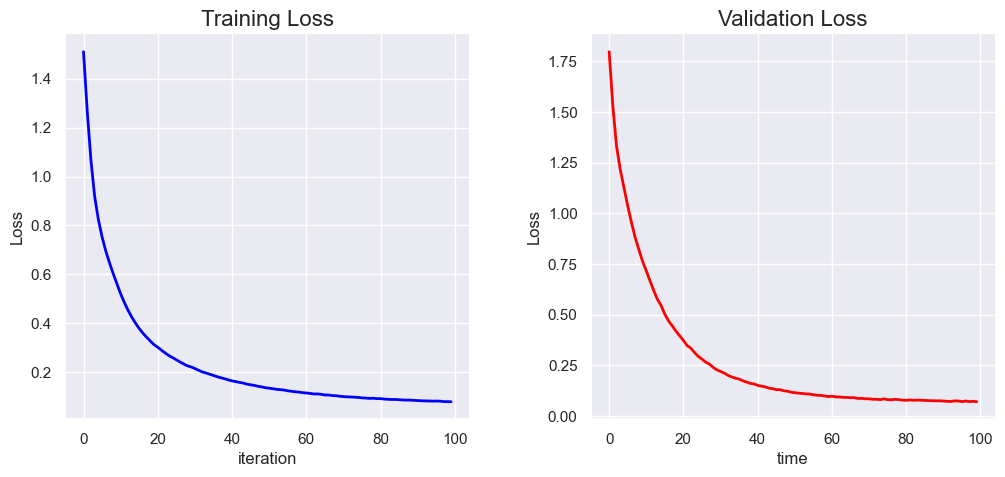

In [34]:
student_model = SimpleModel().to(device)
final_train_student(labeled_train_loader, valid_loader, student_model, teacher_model, "Student", epochs_num = num_epoch)

In [35]:
# Test student 測試集Acc
test_acc = 0
student_model = SimpleModel().to(device)
student_model.load_state_dict(torch.load(config['save_path_small']))
student_model.eval()
with torch.no_grad():
    print("\nnow we can test the accuracy in the test set: ")
    for datas, labels, _ in test_loader:
        datas, labels = datas.to(device), labels.to(device)
        outputs = student_model(datas)
        _, test_pred = torch.max(outputs, 1)
        test_acc += (test_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
    print(f"test acc: {test_acc/(len(dataset_test))}")


now we can test the accuracy in the test set: 
test acc: 0.9232464193903782


In [36]:
!pip install torchinfo

  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata


In [37]:
from torchinfo import summary
summary(teacher_model, input_size=(config['batch_size'],16))

Layer (type:depth-idx)                   Output Shape              Param #
ComplexModel                             [16, 7]                   600
├─Linear: 1-1                            [16, 216]                 3,672
├─LeakyReLU: 1-2                         [16, 216]                 --
├─Dropout: 1-3                           [16, 216]                 --
├─Linear: 1-4                            [16, 128]                 27,776
├─ReLU: 1-5                              [16, 128]                 --
├─Dropout: 1-6                           [16, 128]                 --
├─Linear: 1-7                            [16, 42]                  5,418
├─ReLU: 1-8                              [16, 42]                  --
├─Linear: 1-9                            [16, 7]                   301
Total params: 37,767
Trainable params: 37,767
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.15
Estimated Total Size

In [38]:
summary(student_model, input_size=(config['batch_size'],16))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleModel                              [16, 7]                   --
├─Linear: 1-1                            [16, 42]                  714
├─ReLU: 1-2                              [16, 42]                  --
├─Linear: 1-3                            [16, 7]                   301
Total params: 1,015
Trainable params: 1,015
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01